# **1. Perkenalan Dataset**


**Dataset Mobil Bekas Singapura**

Dataset ini berisi 17.460 data mobil bekas di Singapura, diambil dari [*Kaggle*](https://www.kaggle.com/datasets/shaneyeung/sg-secondhand-car-listings). Cocok digunakan untuk analisis **clustering**.

- 🔢 4 kolom numerikal  
- 🏷️ 4 kolom kategorikal  

Tujuan clustering: mengelompokkan mobil berdasarkan kemiripan fitur untuk memahami segmentasi pasar.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [225]:
dataset = "https://raw.githubusercontent.com/aesxiety/Coding-Camp-DBS/main/Belajar%20Machine%20Learning%20untuk%20Pemula/Dataset/Dataset_inisiasi.csv"

try:
  df = pd.read_csv(dataset)
  print("Data berhasil dibaca!")
  print("Jumlah baris dan kolom:", df.shape)
except FileNotFoundError:
  print(f"Error: Tidak ditemukan {dataset}. coba cek dataset.")
except pd.errors.ParserError:
    print(f"Error: Tidak bisa digunakan {dataset}. coba cek format filenya.")
except Exception as e:
    print(f"Error: {e}")

Data berhasil dibaca!
Jumlah baris dan kolom: (17460, 8)


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17460 entries, 0 to 17459
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               17460 non-null  object 
 1   price              17460 non-null  object 
 2   depreciation       17027 non-null  float64
 3   registration_date  17460 non-null  object 
 4   mileage            17460 non-null  int64  
 5   owners             17372 non-null  float64
 6   listing_url        17460 non-null  object 
 7   brand              17460 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.1+ MB


Terdapat format tipe data yang perlu diperbaiki untuk melakukan eksplorasi data yang tepat

In [227]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['registration_date'] = pd.to_datetime(df['registration_date'], errors='coerce')

Konversi registration_date menjadi rentang usia mobil untuk melihat distribusi usia mobil yang beredar dipasar

In [228]:
reference_date = df["registration_date"].max()
df["carage"] = (reference_date - df["registration_date"]).dt.days // 365

Melihat Missing Value pada dataset

In [229]:
def missing_summary(data) :
    missing_summary = pd.DataFrame({
        'Total Missing': data.isnull().sum(),
        'Percentage': data.isnull().sum() / len(df) * 100
      })
    print(missing_summary)

In [230]:
missing_summary(df)

                   Total Missing  Percentage
name                           0    0.000000
price                         10    0.057274
depreciation                 433    2.479954
registration_date             82    0.469645
mileage                        0    0.000000
owners                        88    0.504009
listing_url                    0    0.000000
brand                          0    0.000000
carage                        82    0.469645


Nilai percentage null < 5%, aman untuk drop barisnya pada tahap preprocessing

**Statistik Deskriptif**

In [231]:
df.describe(include="all")

,name,price,depreciation,registration_date,mileage,owners,listing_url,brand,carage
count,17460,1.745000e+04,17027.000000,17378,1.746000e+04,17372.000000,17460,17460,17378.000000
unique,6175,NaN,NaN,NaN,NaN,NaN,16917,74,NaN
top,Honda Vezel 1.5A X,NaN,NaN,NaN,NaN,NaN,https://www.sgcarmart.com/used_cars/info.php?I...,mercedes-benz,NaN
freq,146,NaN,NaN,NaN,NaN,NaN,3,2574,NaN
mean,NaN,1.275328e+05,21462.362718,2016-08-02 13:57:15.101853184,7.323468e+04,2.403580,NaN,NaN,7.928012
min,NaN,0.000000e+00,3530.000000,1956-02-01 00:00:00,0.000000e+00,1.000000,NaN,NaN,0.000000
25%,NaN,4.955500e+04,12890.000000,2014-09-24 06:00:00,2.200000e+04,1.000000,NaN,NaN,4.000000
50%,NaN,7.980000e+04,15810.000000,2017-08-30 00:00:00,7.400000e+04,2.000000,NaN,NaN,7.000000
75%,NaN,1.388000e+05,21315.000000,2020-01-13 00:00:00,1.097000e+05,3.000000,NaN,NaN,10.000000
max,NaN,3.380000e+06,776690.000000,2025-01-01 00:00:00,9.999999e+06,6.000000,NaN,NaN,68.000000


**Visualisasi EDA**

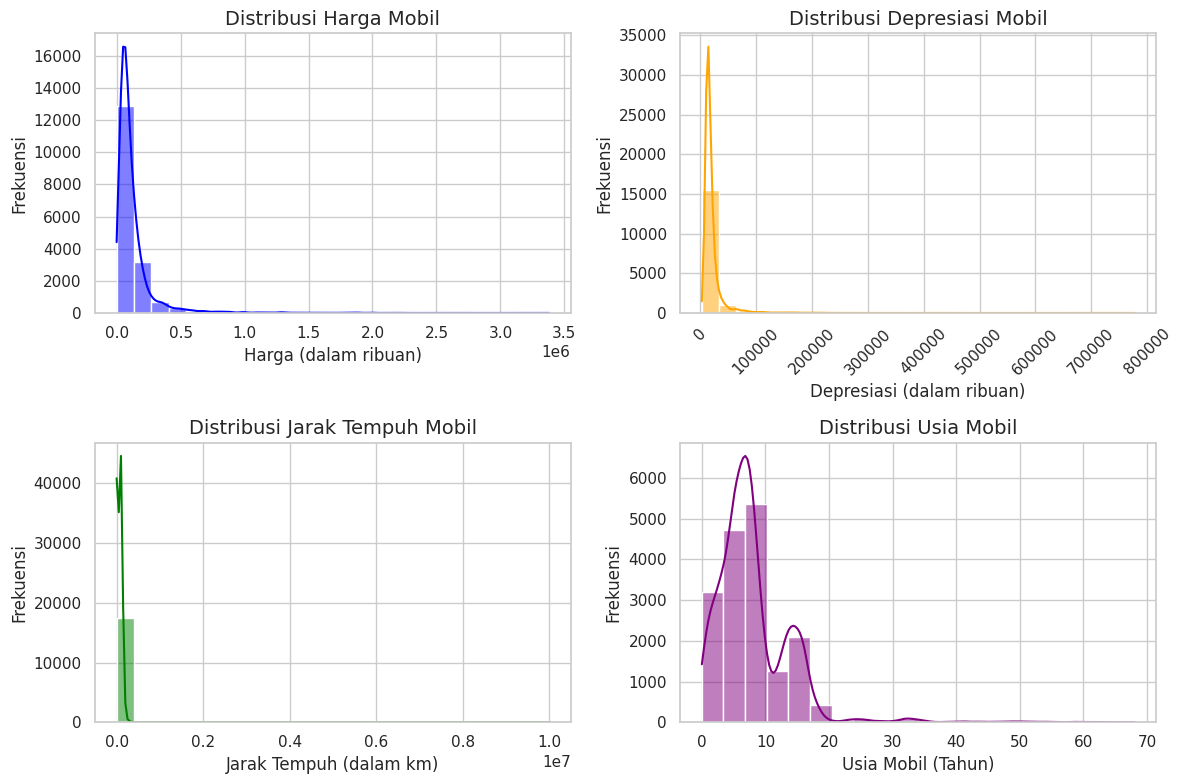

In [232]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df['price'], bins=25, kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title("Distribusi Harga Mobil", fontsize=14)
axes[0, 0].set_xlabel("Harga (dalam ribuan)")
axes[0, 0].set_ylabel("Frekuensi")

sns.histplot(df['depreciation'], bins=25, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title("Distribusi Depresiasi Mobil", fontsize=14)
axes[0, 1].set_xlabel("Depresiasi (dalam ribuan)")
axes[0, 1].set_ylabel("Frekuensi")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.histplot(df['mileage'], bins=25, kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title("Distribusi Jarak Tempuh Mobil", fontsize=14)
axes[1, 0].set_xlabel("Jarak Tempuh (dalam km)")
axes[1, 0].set_ylabel("Frekuensi")

sns.histplot(df['carage'], bins=20, kde=True, color="purple", ax=axes[1, 1])
axes[1, 1].set_title("Distribusi Usia Mobil", fontsize=14)
axes[1, 1].set_xlabel("Usia Mobil (Tahun)")
axes[1, 1].set_ylabel("Frekuensi")

plt.tight_layout()
plt.show()

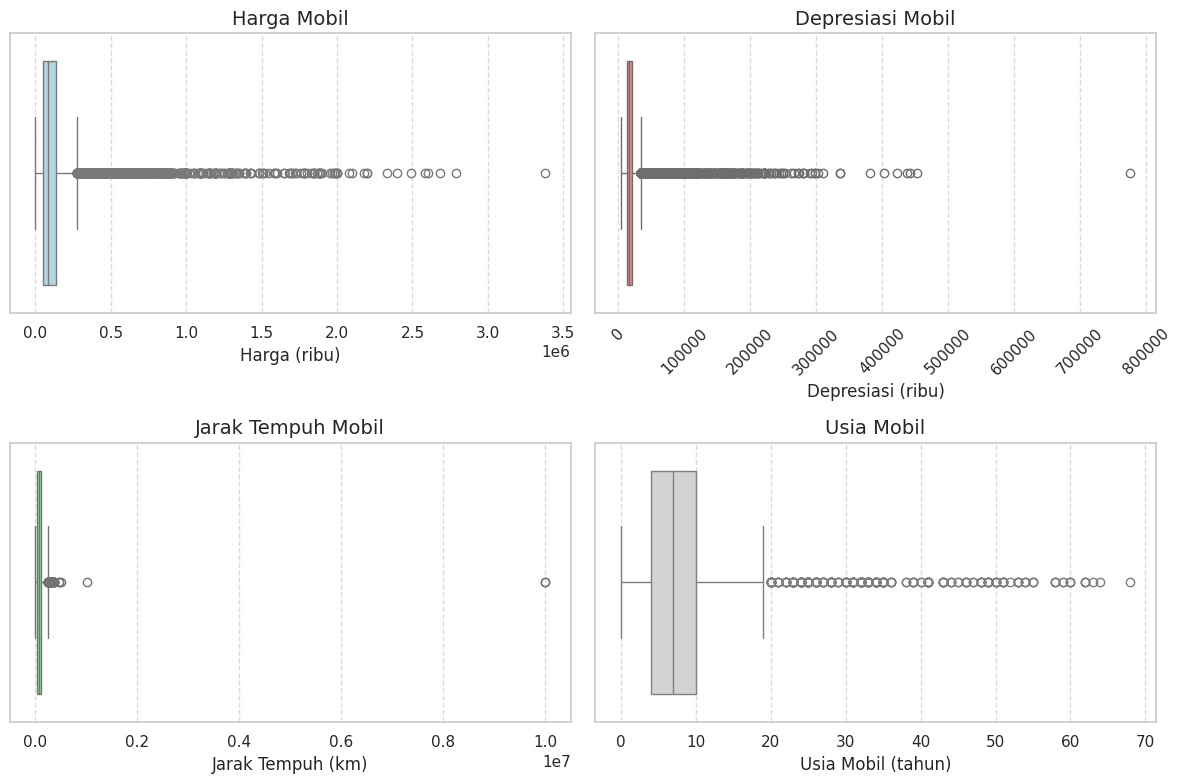

In [233]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x=df['price'], color='lightblue', ax=axes[0,0])
axes[0,0].set_title("Harga Mobil", fontsize=14)
axes[0,0].set_xlabel("Harga (ribu)", fontsize=12)
axes[0,0].grid(axis='x', linestyle='--', alpha=0.7)

sns.boxplot(x=df['depreciation'], color='lightcoral', ax=axes[0,1])
axes[0,1].set_title("Depresiasi Mobil", fontsize=14)
axes[0,1].set_xlabel("Depresiasi (ribu)", fontsize=12)
axes[0,1].grid(axis='x', linestyle='--', alpha=0.7)
axes[0,1].tick_params(axis='x', rotation=45)

sns.boxplot(x=df['mileage'], color='lightgreen', ax=axes[1,0])
axes[1,0].set_title("Jarak Tempuh Mobil", fontsize=14)
axes[1,0].set_xlabel("Jarak Tempuh (km)", fontsize=12)
axes[1,0].grid(axis='x', linestyle='--', alpha=0.7)

sns.boxplot(x=df['carage'], color='lightgray', ax=axes[1,1])
axes[1,1].set_title("Usia Mobil", fontsize=14)
axes[1,1].set_xlabel("Usia Mobil (tahun)", fontsize=12)
axes[1,1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

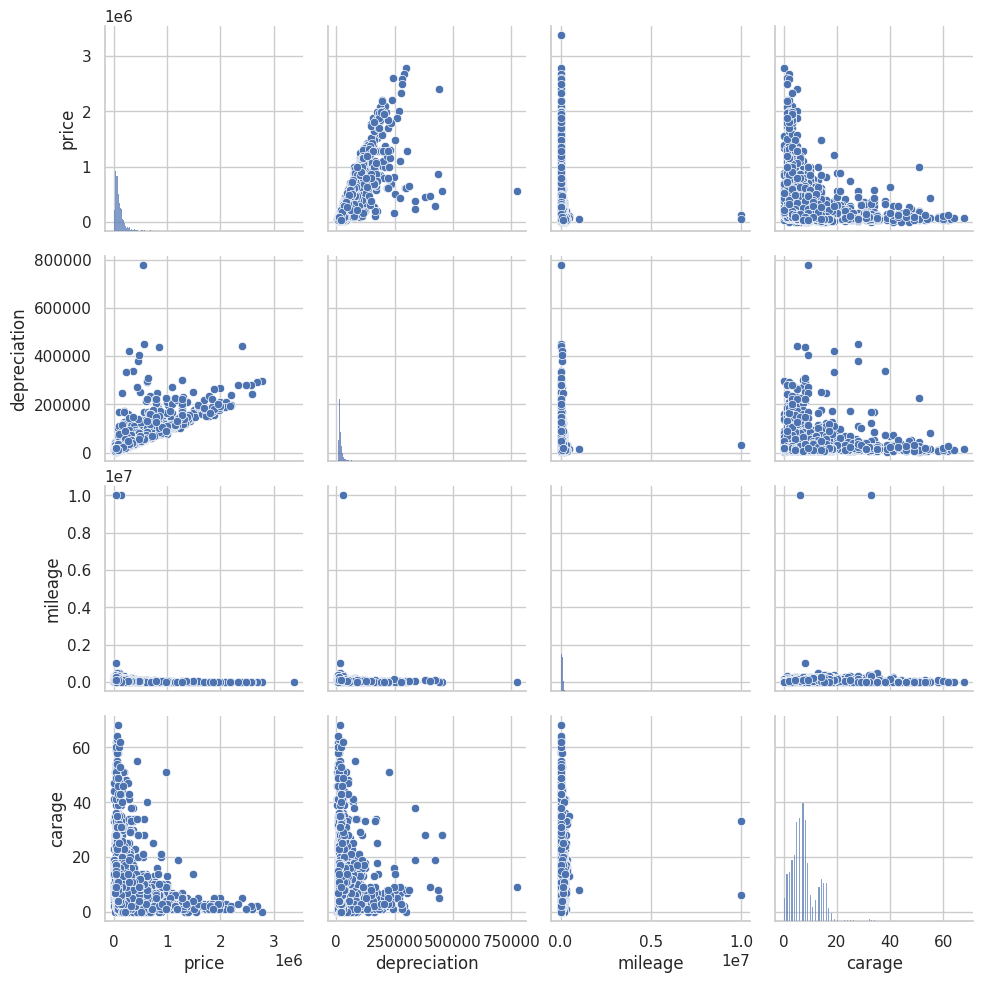

In [234]:
sns.pairplot(df[['price', 'depreciation', 'mileage','carage']])
plt.show()

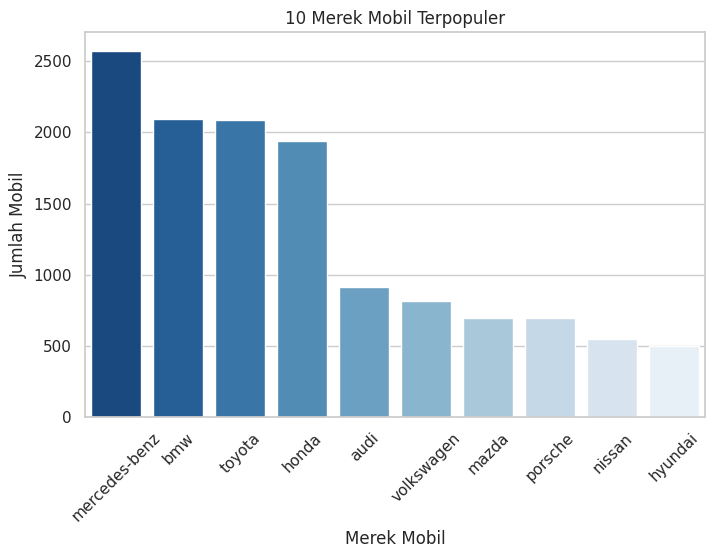

In [235]:
top_brands = df['brand'].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_brands.index, y=top_brands.values, palette="Blues_r")
plt.xlabel("Merek Mobil")
plt.ylabel("Jumlah Mobil")
plt.title("10 Merek Mobil Terpopuler")
plt.xticks(rotation=45)

plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

**Drop kolom yang tidak dibutuhkan**

untuk menjaga data asli buat variabel baru

In [236]:
df_clean = df.drop(columns=["name","owners","listing_url","registration_date"])
df_clean.head()

,price,depreciation,mileage,brand,carage
0,238888.0,26790.0,10000,suzuki,1.0
1,42800.0,11660.0,0,citroen,7.0
2,51800.0,9060.0,0,toyota,14.0
3,22802.0,16210.0,0,honda,8.0
4,20800.0,9010.0,0,citroen,8.0


**Handling Missing Value**

In [237]:
print("Sebelum dropna:", df_clean.shape)
df_clean = df_clean.dropna(subset=['price', 'depreciation', 'carage'])
print("Setelah dropna:", df_clean.shape)

Sebelum dropna: (17460, 5)
Setelah dropna: (17027, 5)


**Handling data duplikat**

In [238]:
print("\n🔄 Jumlah duplikasi sebelum dihapus:", df_clean.duplicated().sum())

if df_clean.duplicated().sum() > 0:
    df_clean.drop_duplicates(inplace=True)
    print("✅ Duplikasi ditemukan dan telah dihapus.")
    print("✅ Jumlah duplikasi setelah dihapus:", df_clean.duplicated().sum())
else:
    print("❌ Tidak ada duplikasi dalam dataset.")


🔄 Jumlah duplikasi sebelum dihapus: 195
✅ Duplikasi ditemukan dan telah dihapus.
✅ Jumlah duplikasi setelah dihapus: 0


Bedasarkan visualisasi pada tahap *EDA* ditemukan outlier pada  `'price'`,`'mileage'`,`'depreciation'` dan `'carage'`
Menggunakan metode IQR untuk menghapus outlier .

In [239]:
def remove_outliers(df, column):
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

In [240]:
print(f"Data sebelum outlier dihapus: {df_clean.shape}")
for col in ['price', 'mileage', 'depreciation','carage']:
    df_clean = remove_outliers(df_clean, col)

print(f"Data setelah outlier dihapus: {df_clean.shape}")

Data sebelum outlier dihapus: (16832, 5)
Data setelah outlier dihapus: (14354, 5)


**Encoding Data Kategorikal**

In [241]:
le_brand = LabelEncoder()
df_clean['brand'] = le_brand.fit_transform(df_clean['brand'])

In [242]:
robust_scaler = RobustScaler()

df_clean[['price', 'mileage','depreciation','carage']] = robust_scaler.fit_transform(
    df_clean[['price', 'mileage', 'depreciation','carage']])
print("\n Normalization Done :)")


 Normalization Done :)


In [243]:
df_clean.head(2)

,price,depreciation,mileage,brand,carage
0,2.457009,1.868463,-0.899960,56,-1.5
1,-0.460967,-0.529319,-1.028526,12,0.0


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [244]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(df_clean)

array([1, 0, 1, ..., 0, 1, 2], dtype=int32)

##b. Evaluasi Model Clustering

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

**Hitung Silhouette Score untuk hasil clustering dengan asumsi 3 clusters**

In [245]:
score = silhouette_score(df_clean, kmeans.labels_)
print(f"Silhouette Score untuk 3 cluster: {score:.4f}")

Silhouette Score untuk 3 cluster: 0.6514


**Evaluasi model dengan menggunakan Elbow Method dan validasi lagi menggunkan Sihouette Score**

In [246]:
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(df_clean)
    inertia.append(kmeans_test.inertia_)
    silhouette_scores.append(silhouette_score(df_clean, kmeans_test.labels_))

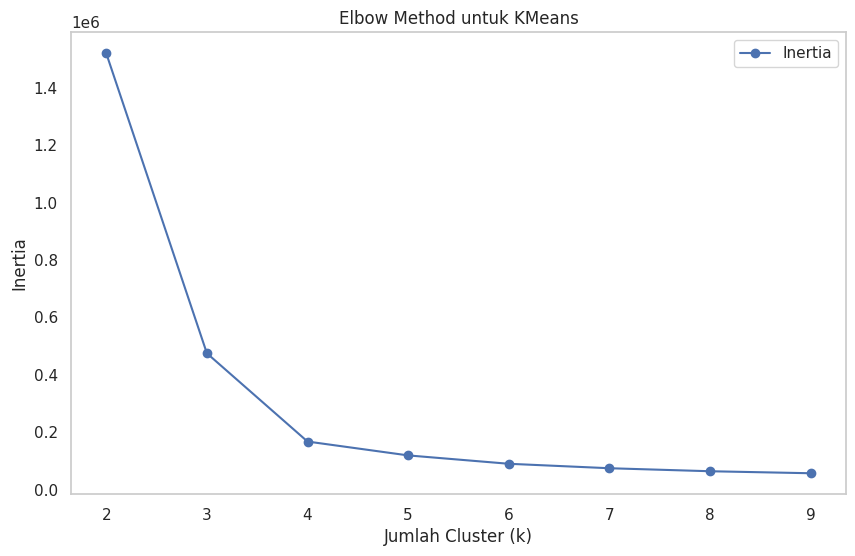

In [247]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk KMeans')
plt.legend()
plt.grid()
plt.show()

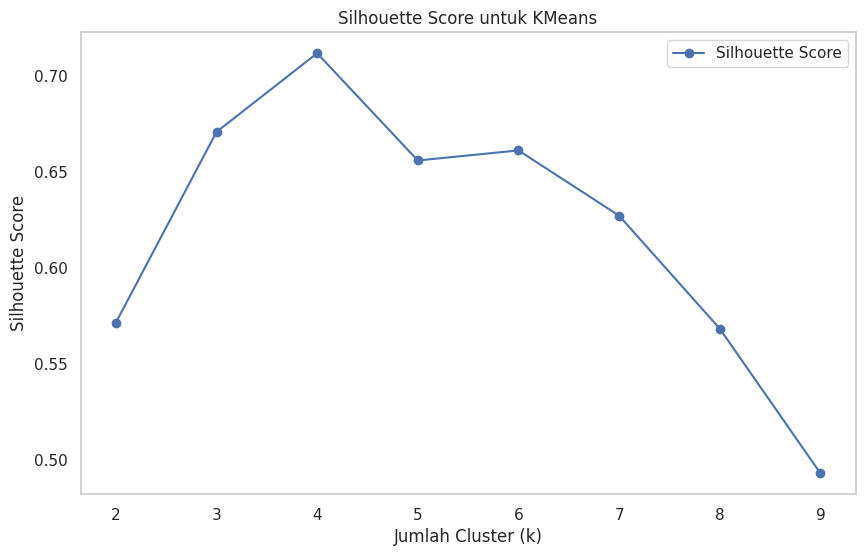

In [248]:
# Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk KMeans')
plt.legend()
plt.grid()
plt.show()

In [249]:
best_k = K[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\nJumlah cluster optimal (KMeans): {best_k} dengan Silhouette Score: {best_score:.4f}")


Jumlah cluster optimal (KMeans): 4 dengan Silhouette Score: 0.7120


Terapkan jumlah cluster optimal ke dalam model

In [250]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit_predict(df_clean)

array([1, 3, 1, ..., 3, 1, 2], dtype=int32)

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [251]:
#

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

**Proyeksi PCA ke 2 dimensi**

In [252]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_clean)

**Visualisasi hasil clustering**

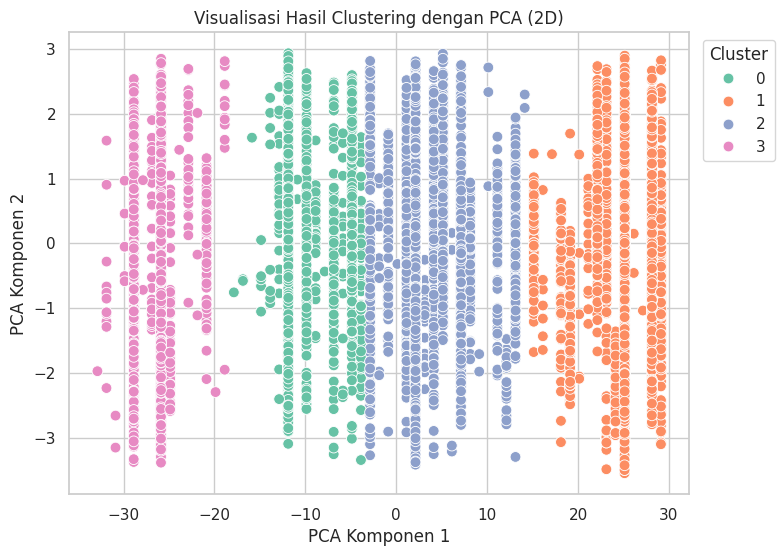

In [253]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=kmeans.labels_,
    palette='Set2',
    s=60
)
plt.title("Visualisasi Hasil Clustering dengan PCA (2D)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.15, 1), loc='upper right')
plt.show()

🔍 **Insight Hasil Clustering (PCA 2D)**
* Hasil visualisasi menunjukkan bahwa data terbagi menjadi 4 cluster yang terpisah dengan jelas.

* PCA Komponen 1 menjadi pembeda utama antar cluster, menunjukkan peran dominan fitur-fitur seperti price, mileage, dan depreciation.

* Setiap cluster memiliki pola distribusi yang berbeda, yang bisa merepresentasikan kelompok mobil berdasarkan harga dan kondisi penggunaannya.

* Tidak ada tumpang tindih signifikan, sehingga model KMeans dengan k = 4 dianggap cukup optimal dalam memisahkan data.


## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.


In [254]:
df_clean['Cluster'] = kmeans.labels_

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi.


In [255]:
le_brand.inverse_transform(df_clean[['brand']])

array(['suzuki', 'citroen', 'toyota', ..., 'bmw', 'volkswagen',
       'mercedes-benz'], dtype=object)

Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru

In [256]:
df_clean['brand'] = le_brand.inverse_transform(df_clean[['brand']])

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:

In [257]:
df_clean['price'] = robust_scaler.inverse_transform(df_clean[['price', 'mileage','depreciation','carage']])[:,0]
df_clean['mileage'] = robust_scaler.inverse_transform(df_clean[['price', 'mileage','depreciation','carage']])[:, 1]
df_clean['depreciation'] = robust_scaler.inverse_transform(df_clean[['price', 'mileage','depreciation','carage']])[:, 2]
df_clean['carage'] = robust_scaler.inverse_transform(df_clean[['price', 'mileage','depreciation','carage']])[:, 3]

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [258]:
cluster_summary_kmeans = df_clean.groupby('Cluster').agg({
    'price': ['min', 'max', 'mean'],
    'depreciation': ['min', 'max', 'mean'],
    'mileage': ['min', 'max', 'mean'],
    'carage': ['min', 'max', 'mean'],
    'brand': lambda x: x.mode()[0],
}).reset_index()

print("\nRingkasan Cluster KMeans Optimal:")
cluster_summary_kmeans


Ringkasan Cluster KMeans Optimal:


Cluster   price                          depreciation           \
              min       max           mean          min      max   
0       0  6000.0  263800.0   69558.365198       6870.0  30120.0   
1       1  6800.0  270000.0   82387.831827       3530.0  30200.0   
2       2  7550.0  269800.0   91955.655464       5810.0  30160.0   
3       3  7000.0  270000.0  101533.683299       6760.0  30210.0   

                mileage                         carage                  \
           mean     min       max          mean    min   max      mean   
0  14513.110823     0.0  230000.0  72573.886585    0.0  17.0  7.183733   
1  15681.958368     0.0  230000.0  73221.247877    0.0  17.0  7.288414   
2  16834.098499     0.0  229606.0  77751.246882    0.0  17.0  7.623547   
3  17381.902287     0.0  231000.0  79323.316008    0.0  17.0  7.790367   

           brand  
        <lambda>  
0          honda  
1         toyota  
2  mercedes-benz  
3            bmw

### **Analisis Karakteristik Cluster Penjualan Mobil Bekas**

**Cluster 0 - Budget Smart Choice**
* Rata-rata harga: SGD 69.558.000 (terendah di antara semua cluster)
* Depresiasi : SGD 14,513 rata-rata per tahun
* Mileage: 72.574 km (relatif rendah)
* Usia mobil rata-rata: 7.18 tahun
* Brand dominan: Honda

✅ Insight:

Cluster ini mencerminkan mobil yang cukup tua namun ekonomis. Sangat cocok bagi pembeli dengan anggaran terbatas atau yang mencari kendaraan harian tanpa fokus pada merek premium.

___
**Cluster 1 -Reliable Investment**

* Rata-rata harga: SGD 82,388
* Depresiasi: Paling rendah, hanya SGD 15.682.000
* Mileage: 73.221 mil
* Usia mobil rata-rata: 7.29 tahun
* Brand dominan: Toyota

✅ Insight: Mobil di cluster ini memiliki depresiasi paling kecil, menandakan nilai jual kembali yang stabil. Brand dominan Toyota yang mewakili cluster ini dikenal akan keandalannya. Mobil dalam cluster ini seimbang antara harga dan performa, cocok untuk keluarga atau pengguna umum yang ingin kendaraan berkualitas tanpa terlalu mahal.
___

Cluster 2 - Affordable Luxury
* Rata-rata harga: SGD 91,956
* Depresiasi: SGD 16.834.000
* Mileage: 77.751 mil
* Usia mobil rata-rata: 7.62 tahun
* Brand dominan: Mercedes-Benz

✅ Insight: Cluster ini merupakan segmen menengah-atas dengan harga lebih tinggi yang didominasi Brand Mercedes-Benz.
Mileage dan usia sedikit lebih tinggi dari cluster sebelumnya. Cocok untuk pembeli yang mencari mobil premium dengan harga masuk akal.
___

Cluster 3 - High-End Enthusiast
* Rata-rata harga: SGD 101,534
* Depresiasi: Tertinggi, SGD 17.382.000
* Mileage: 79.323 mil (tertinggi)
* Usia mobil rata-rata: 7.79 tahun (paling tua)
* Brand dominan: BMW

✅ Insight: Ini adalah cluster dengan posisi tertinggi dari segi harga, depresiasi, dan usia yang di dominasi brand BMW.
Menunjukkan mobil-mobil premium yang cenderung lebih mahal untuk dimiliki maupun dirawat. Cocok untuk segmen pengguna yang mencari prestige dan performa tinggi meskipun usia dan jarak tempuh cukup tinggi.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [259]:
df_clean.to_csv('Dataset_hasil_clustering.csv', index=False)
print("\n Hasil clustering berhasil disimpan dalam file: Dataset_hasil_clustering.csv")


 Hasil clustering berhasil disimpan dalam file: Dataset_hasil_clustering.csv
